In [75]:
# %matplotlib widget

from __future__ import annotations

import re
from collections import defaultdict
from dataclasses import dataclass, field
from itertools import permutations, product
from math import inf
from random import choice

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
from mpl_toolkits.mplot3d import axes3d
from numpy import int_, object_
from numpy.typing import NDArray
from test_utilities import run_tests_params
from util import print_hex

COLORS = list(mcolors.CSS4_COLORS.keys())

<link href="style.css" rel="stylesheet"></link>
<article class="day-desc read-aloud"><h2>--- Day 13: Transparent Origami ---</h2><p>You reach another volcanically active part of the cave. It would be nice if you could do some kind of thermal imaging so you could tell ahead of time which caves are too hot to safely enter.</p>
<p>Fortunately, the submarine seems to be equipped with a thermal camera! When you activate it, you are greeted with:</p>
<pre><code>Congratulations on your purchase! To activate this infrared thermal imaging
camera system, please enter the code found on page 1 of the manual.
</code></pre>
<p>Apparently, the Elves have never used this feature. To your surprise, you manage to find the manual; as you go to open it, page 1 falls out. It's a large sheet of <a href="https://en.wikipedia.org/wiki/Transparency_(projection)" target="_blank">transparent paper</a>! The transparent paper is marked with random dots and includes instructions on how to fold it up (your puzzle input). For example:</p>
<pre><code>6,10
0,14
9,10
0,3
10,4
4,11
6,0
6,12
4,1
0,13
10,12
3,4
3,0
8,4
1,10
2,14
8,10
9,0

fold along y=7
fold along x=5
</code></pre>

<p>The first section is a list of dots on the transparent paper. <code>0,0</code> represents the top-left coordinate.  The first value, <code>x</code>, increases to the right.  The second value, <code>y</code>, increases downward.  So, the coordinate <code>3,0</code> is to the right of <code>0,0</code>, and the coordinate <code>0,7</code> is below <code>0,0</code>. The coordinates in this example form the following pattern, where <code>#</code> is a dot on the paper and <code>.</code> is an empty, unmarked position:</p>
<pre><code>...#..#..#.
....#......
...........
#..........
...#....#.#
...........
...........
...........
...........
...........
.#....#.##.
....#......
......#...#
#..........
#.#........
</code></pre>
<p>Then, there is a list of <em>fold instructions</em>. Each instruction indicates a line on the transparent paper and wants you to fold the paper <em>up</em> (for horizontal <code>y=...</code> lines) or <em>left</em> (for vertical <code>x=...</code> lines). In this example, the first fold instruction is <code>fold along y=7</code>, which designates the line formed by all of the positions where <code>y</code> is <code>7</code> (marked here with <code>-</code>):</p>
<pre><code>...#..#..#.
....#......
...........
#..........
...#....#.#
...........
...........
-----------
...........
...........
.#....#.##.
....#......
......#...#
#..........
#.#........
</code></pre>
<p>Because this is a horizontal line, fold the bottom half <em>up</em>. Some of the dots might end up overlapping after the fold is complete, but dots will never appear exactly on a fold line. The result of doing this fold looks like this:</p>
<pre><code>#.##..#..#.
#...#......
......#...#
#...#......
.#.#..#.###
...........
...........
</code></pre>
<p>Now, only <code>17</code> dots are visible.</p>
<p>Notice, for example, the two dots in the bottom left corner before the transparent paper is folded; after the fold is complete, those dots appear in the top left corner (at <code>0,0</code> and <code>0,1</code>). Because the paper is transparent, the dot just below them in the result (at <code>0,3</code>) remains visible, as it can be seen through the transparent paper.</p>
<p>Also notice that some dots can end up <em>overlapping</em>; in this case, the dots merge together and become a single dot.</p>
<p>The second fold instruction is <code>fold along x=5</code>, which indicates this line:</p>
<pre><code>#.##.|#..#.
#...#|.....
.....|#...#
#...#|.....
.#.#.|#.###
.....|.....
.....|.....
</code></pre>
<p>Because this is a vertical line, fold <em>left</em>:</p>
<pre><code>#####
#...#
#...#
#...#
#####
.....
.....
</code></pre>
<p>The instructions made a square!</p>
<p>The transparent paper is pretty big, so for now, focus on just completing the first fold. After the first fold in the example above, <code><em>17</em></code> dots are visible - dots that end up overlapping after the fold is completed count as a single dot.</p>
<p><em>How many dots are visible after completing just the first fold instruction on your transparent paper?</em></p>
</article>


In [76]:
from itertools import islice
from pprint import pprint

from matplotlib import colors
from more_itertools import first


example = """
6,10
0,14
9,10
0,3
10,4
4,11
6,0
6,12
4,1
0,13
10,12
3,4
3,0
8,4
1,10
2,14
8,10
9,0

fold along y=7
fold along x=5
"""


class TransparentPaper:
    def __init__(self, s: str | None = None) -> None:
        if s is None:
            self._init_empty_TransparentPaper()
        else:
            self._init_from_str(s)

    def _init_empty_TransparentPaper(self):
        self.dots = set()
        self.folds = []
        self.max_x = 0
        self.max_y = 0

    def _init_from_str(self, s):
        dots, folds = re.split(r"\n\s*\n", s.strip())
        self.dots = {tuple(int(i) for i in l.split(",")) for l in dots.splitlines()}
        self.folds = [
            (f[11:].split("=")[0], int(f[11:].split("=")[1]))
            for f in folds.splitlines()
        ]

        self.max_x = max(x for x, _ in self.dots)
        self.max_y = max(y for _, y in self.dots)

    def fold_left(self, x_fold: int) -> TransparentPaper:
        tp = TransparentPaper()

        max_d = max(x_fold, (self.max_x - x_fold))
        tp.dots = {(max_d - abs(x - x_fold), y) for x, y in self.dots if x != x_fold}

        tp.folds = [
            (t, max_d - abs(x - x_fold))
            for t, x in islice(self.folds, 1, len(self.folds))
        ]

        tp.max_x = max_d - 1
        tp.max_y = self.max_y

        return tp

    def fold_up(self, y_fold: int) -> TransparentPaper:
        tp = TransparentPaper()

        max_d = max(y_fold, (self.max_y - y_fold))
        tp.dots = {(x, max_d - abs(y - y_fold)) for x, y in self.dots if y != y_fold}

        tp.folds = [
            (t, max_d - abs(y - y_fold))
            for t, y in islice(self.folds, 1, len(self.folds))
        ]

        tp.max_x = self.max_x
        tp.max_y = max_d - 1

        return tp

    def plot(self) -> None:

        display = [
            [20 if (x, y) in self.dots else 0 for x in range(self.max_x + 1)]
            for y in range(self.max_y + 1)
        ]

        cmap = colors.ListedColormap(["black", "green"])
        bounds = [0, 10, 20]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        _, ax = plt.subplots()
        ax.imshow(display, cmap=cmap, norm=norm)
        plt.grid(False)
        plt.axis("off")
        plt.show()

    def __repr__(self) -> str:
        return (
            f"{type(self).__name__}:\n"
            + (
                f"max x = {self.max_x}, max y = {self.max_y}\n\n"
                + "\n".join(
                    "".join(
                        f"{'#' if (x, y) in self.dots else '.'}"
                        for x in range(self.max_x + 1)
                    )
                    for y in range(self.max_y + 1)
                )
                if self.dots
                else ""
            )
            + "\n\n"
            + f"dots={self.dots}\n"
            + f"folds={self.folds}"
        )

    @classmethod
    def dots_after_first_fold(cls, s: str) -> int:
        tp = cls(s)
        first_fold = tp.folds[0]
        if first_fold[0] == "x":
            return len(tp.fold_left(first_fold[1]).dots)
        return len(tp.fold_up(first_fold[1]).dots)

    @classmethod
    def do_all_fold(cls, s: str) -> TransparentPaper:
        tp = cls(s)

        while tp.folds:
            first_fold = tp.folds[0]
            if first_fold[0] == "x":
                tp = tp.fold_left(first_fold[1])
            else:
                tp = tp.fold_up(first_fold[1])
        return tp


assert TransparentPaper.dots_after_first_fold(example) == 17

In [77]:
with open("../input/day13.txt") as f:
    puzzle = f.read()


print(f"Part I: {TransparentPaper.dots_after_first_fold(puzzle)}")

Part I: 847


<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>847</code>.</p><p class="day-success">The first half of this puzzle is complete! It provides one gold star: *</p>
<article class="day-desc"><h2 id="part2">--- Part Two ---</h2><p><span title="How can you fold it that many times? You tell me, I'm not the one folding it.">Finish folding</span> the transparent paper according to the instructions. The manual says the code is always <em>eight capital letters</em>.</p>
<p><em>What code do you use to activate the infrared thermal imaging camera system?</em></p>
</article>

</main>


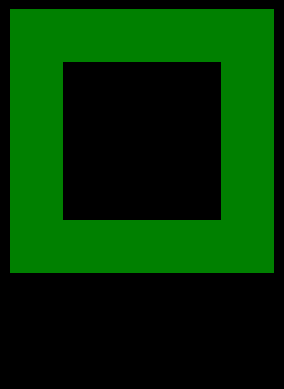

In [78]:
TransparentPaper.do_all_fold(example).plot()

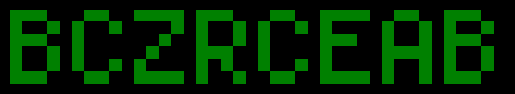

Part II: None


In [81]:
print(f"Part II: { TransparentPaper.do_all_fold(puzzle).plot() }")

<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>BCZRCEAB</code>.</p><p class="day-success">Both parts of this puzzle are complete! They provide two gold stars: **</p>

</main>
